In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import cv2
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Function to apply stain separation annotation
def separate_stains(image):
    # Convert RGB image to grayscale
    gray = rgb2gray(image)
    
    # Apply Otsu's thresholding to separate stains
    thresh = threshold_otsu(gray)
    blue_mask = gray < thresh
    
    # Multiply original image with the blue mask
    blue_stain = np.multiply(image, np.expand_dims(blue_mask, axis=-1))
    return blue_stain

# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False)

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with softmax activation for the fibrosis classification
predictions = Dense(5, activation='softmax')(x)

# Combine the base ResNet50 model with the custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define ImageDataGenerator for data augmentation and loading
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load and augment the images using ImageDataGenerator
train_generator = datagen.flow_from_directory(
        'D:/DATASET/CNN/fibrosis/train',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

model.summary()

In [ ]:
# Fine-tune the model
model.fit(train_generator, epochs=3)

# Unfreeze some layers in the base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model to apply changes
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
#model.fit(train_generator, epochs=10)

In [ ]:
import json

# Save history to JSON file
fibrosis_history = fibrosis_model.fit(train_generator, epochs=10, validation_data=validation_generator)
with open('D:/DATASET/Models/fibrosis_history.json', 'w') as file:
    json.dump(fibrosis_history.history, file)

In [ ]:
model.save("D:/DATASET/Models/model_fibrosis.h5")

In [ ]:
# Load the model using TensorFlow's built-in method
# model = tf.keras.models.load_model('D:/DATASET/Models/model_fibrosis.h5')

In [ ]:
# Function to generate feature maps
def generate_feature_map(img_path):
    img = load_img(img_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Get feature maps
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('conv5_block3_3_conv').output)
    intermediate_output = intermediate_layer_model.predict(x)
    
    # Plot the feature maps
    plt.figure(figsize=(16, 16))
    for i in range(10):
        plt.subplot(5, 5, i+1)
        plt.imshow(intermediate_output[0, :, :, i], cmap='viridis')
    plt.show()


In [ ]:
# Function to generate Class Activation Map (CAM)
'''def generate_CAM(img_path):
    img = load_img(img_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Get the prediction
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    
    # Get the output of the last convolutional layer
    last_conv_layer = model.get_layer('conv5_block3_3_conv')
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)
    
    # Start gradient tape context
    with tf.GradientTape() as tape:
        # Get the convolutional layer output for the input image
        last_conv_layer_output = last_conv_layer_model(x)
        
        # Watch the convolutional layer output
        tape.watch(last_conv_layer_output)
        
        # Get the prediction for the input image
        preds = model(x)
        # Get the prediction score for the predicted class
        pred_output = preds[:, class_idx]
        
    # Calculate gradients of the predicted class score with respect to the convolutional layer output
    grads = tape.gradient(pred_output, last_conv_layer_output)
    
    
    if grads is not None:
        # Compute global average pooling of the gradients
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Multiply each channel in the feature map array by "how important this channel is" with regard to the predicted class
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = tf.reduce_mean(last_conv_layer_output, axis=-1)
        for i in range(heatmap.shape[-1]):
            heatmap[:, :] += last_conv_layer_output[:, :, i] * pooled_grads[i]

        # Normalize the heatmap
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)

        # Resize heatmap to the size of the original image
        heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))

        # Convert the heatmap to RGB
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Superimpose the heatmap on the original image
        superimposed_img = cv2.addWeighted(img_to_array(img), 0.5, heatmap, 0.5, 0)

        # Plot the images
        plt.imshow(superimposed_img.astype(np.uint8))
        plt.axis('off')
        plt.show()
        print("hello")
'''

In [ ]:
def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

# Function to calculate the area of dark blue stain and overlay contours on the image
def calculate_blue_area(img):
    # Convert image to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Define lower and upper bounds for dark blue color in HSV
    lower_dark_blue = np.array([90, 50, 50])
    upper_dark_blue = np.array([130, 255, 100])  # Adjust this upper bound as needed
    
    # Threshold the HSV image to get only dark blue colors
    mask = cv2.inRange(hsv, lower_dark_blue, upper_dark_blue)
    
    # Find contours of dark blue regions
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the area of dark blue regions and draw contours on the image
    blue_area = 0
    img_with_contours = img.copy()  # Create a copy of the original image
    for contour in contours:
        blue_area += cv2.contourArea(contour)
        cv2.drawContours(img_with_contours, [contour], -1, (0, 255, 0), 2)  # Draw contour on the image
    
    return blue_area, img_with_contours

# Function to make prediction on a single image
def predict_image(img_path, model):
    # Load and preprocess the image
    img = Image.open(img_path)
    #img = img.resize((299, 299))  # Resize the image
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Predict using the model
    preds = model.predict(x)
    print('Predictions:', preds)

    # Get the index of the class with maximum probability
    max_prob_index = np.argmax(preds)
    
    # Define the NASH score mapping
    nash_scores = {
        0: "0: No fibrosis",
        1: "1: Mild/moderate perisinusoidal fibrosis",
        2: "2: Periportal/portal fibrosis",
        3: "3: Bridging fibrosis",
        4: "4: Cirrhosis"
    }
    
    # Get the NASH score corresponding to the maximum probability
    nash_score = nash_scores[max_prob_index]
    
    # Calculate blue area and overlay contours on the image
    blue_area, img_with_contours = calculate_blue_area(np.array(img))
    print('Blue stain area:', blue_area)
    
    # Print the NASH score
    print('Predicted NASH score:', nash_score)
    
    # Display the image with blue contours
    plt.imshow(img_with_contours)
    plt.title('Image with Blue Stain Contours')
    plt.axis('off')
    plt.show()

# Path to the input image
img_path = "D:/Testing (Triya ma'am)/MASSONS TRICHOME SCORING/NASH_massons trichome_40x/5.jpeg"

# Predict NASH score, calculate blue area, and display the image with blue contours
show_image(img_path)
predict_image(img_path, model)


In [ ]:
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Function to crop the large image into patches of size 299x299
def crop_image(image_path, patch_size=(299, 299)):
    img = Image.open(image_path)
    width, height = img.size
    patches = []
    for x in range(0, width, patch_size[0]):
        for y in range(0, height, patch_size[1]):
            patch = img.crop((x, y, x + patch_size[0], y + patch_size[1]))
            patches.append(patch)
    return patches

# Function to make prediction on a single image patch
def predict_patch(patch, model):
    x = img_to_array(patch)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    max_prob_index = np.argmax(preds)
    return max_prob_index

# Function to calculate the average NASH score
def calculate_average_nash_score(image_path, model):
    patches = crop_image(image_path)
    nash_scores = []
    for patch in patches:
        nash_score = predict_patch(patch, model)
        nash_scores.append(nash_score)
    average_nash_score = np.mean(nash_scores)
    return int(np.round(average_nash_score, 0))

# Path to the large image
image_path = "D:/Testing (Triya ma'am)/MASSONS TRICHOME SCORING/NAFLD Massons trichome_40x/x3.jpg"

# Calculate average NASH score
average_nash_score = calculate_average_nash_score(image_path, model)
    
# Define the NASH score mapping
nash_scores = {
    0: "0: No fibrosis",
    1: "1: Mild/moderate perisinusoidal fibrosis",
    2: "2: Periportal/portal fibrosis",
    3: "3: Bridging fibrosis",
    4: "4: Cirrhosis"
}
    
# Get the NASH score corresponding to the maximum probability
nash_score = nash_scores[average_nash_score]
    
# Print the NASH score
print('Predicted NASH score:', nash_score)
show_image(image_path)


In [1]:
from PIL import Image

def convert_to_grayscale(image_path):
    # Open the image
    image = Image.open(image_path)
    
    # Convert the image to grayscale
    grayscale_image = image.convert('L')
    
    # Save or display the grayscale image
    grayscale_image.show()  # Show the grayscale image
    # grayscale_image.save('grayscale_image.jpg')  # Save the grayscale image to a file

# Example usage
convert_to_grayscale("D:/DATASET/CNN/fibrosis/train/3/47_97_13.png")

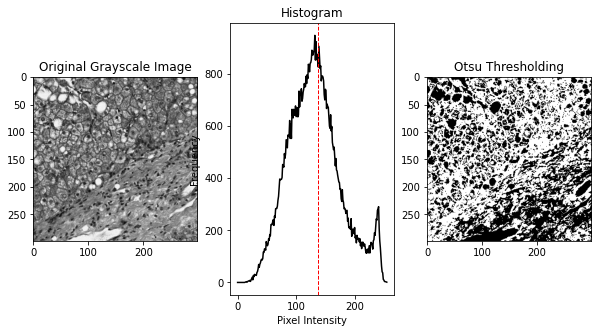

In [28]:
from PIL import Image
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

def apply_otsu_thresholding(image_path):
    # Open the image
    image = Image.open(image_path)
    
    # Convert RGB image to grayscale
    gray = rgb2gray(np.array(image))
    
    # Calculate histogram of pixel intensities
    hist, bins = np.histogram(gray.flatten(), bins=256, range=(0, 1))
    
    # Display original grayscale image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(gray, cmap='gray')
    plt.title('Original Grayscale Image')
    
    # Plot histogram
    plt.subplot(1, 3, 2)
    plt.plot(hist, color='black')
    plt.title('Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    
    # Apply Otsu's thresholding
    thresh = threshold_otsu(gray)
    binary_image = gray > thresh
    
    # Display thresholded binary image
    plt.subplot(1, 3, 3)
    plt.imshow(binary_image, cmap='binary')
    plt.title('Otsu Thresholding')
    
    # Highlight threshold on histogram
    plt.subplot(1, 3, 2)
    plt.axvline(thresh * 255, color='red', linestyle='--', linewidth=1)
    
    plt.show()

# Example usage
apply_otsu_thresholding('C:/Users/JUHI/Downloads/fib1.jpg')


[[[202  70  91]
  [  0   0   0]
  [200  83 102]
  ...
  [201  14  69]
  [165   0  58]
  [178  26  77]]

 [[208  70  93]
  [  0   0   0]
  [  0   0   0]
  ...
  [194  17  69]
  [179  20  74]
  [188  40  88]]

 [[233  83 112]
  [  0   0   0]
  [  0   0   0]
  ...
  [178  10  61]
  [196  38  89]
  [219  69 115]]

 ...

 [[ 19  86 138]
  [  9  87 135]
  [ 15 106 150]
  ...
  [238  74 108]
  [  0   0   0]
  [222  39  83]]

 [[  4  91 136]
  [ 22 100 148]
  [ 30 114 160]
  ...
  [233  88 117]
  [229  75 111]
  [209  40  83]]

 [[ 14 126 163]
  [ 24 120 162]
  [ 33 124 168]
  ...
  [  0   0   0]
  [216  75 109]
  [203  40  83]]]


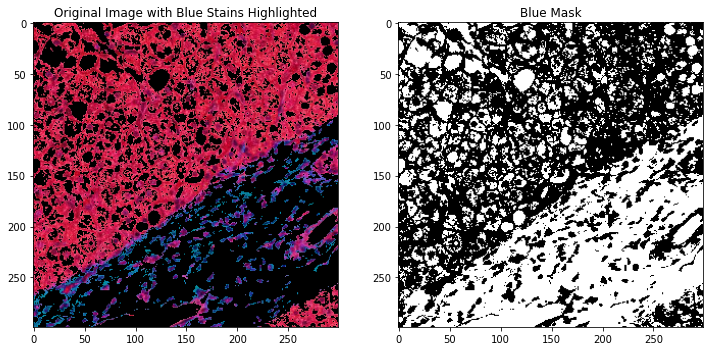

In [34]:
from PIL import Image
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

def apply_otsu_thresholding(image_path):
    # Open the image
    image = Image.open(image_path)
    
    # Convert RGB image to grayscale
    gray = rgb2gray(np.array(image))
    
    # Apply Otsu's thresholding
    thresh = threshold_otsu(gray)
    binary_image = gray > thresh
    
    # Create blue mask
    blue_mask = gray < thresh
    
    # Apply blue mask to the original image
    blue_stain = np.array(image) * np.expand_dims(blue_mask, axis=-1)
    
    print(blue_stain)
    
    # Display original image with only blue-stained regions highlighted
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(blue_stain.astype(np.uint8))  # Convert back to uint8 for display
    plt.title('Original Image with Blue Stains Highlighted')
    
    # Display blue mask
    plt.subplot(1, 2, 2)
    plt.imshow(blue_mask, cmap='binary')
    plt.title('Blue Mask')
    
    plt.show()

# Example usage
apply_otsu_thresholding('C:/Users/JUHI/Downloads/fib5.jpg')



Blue Mask Array:
[[1 0 1 ... 1 1 1]
 [1 0 0 ... 1 1 1]
 [1 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 0 1 1]]


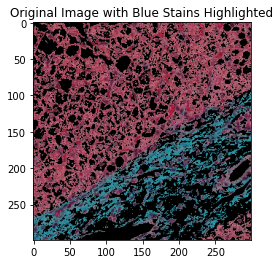

In [30]:
from PIL import Image
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

def apply_otsu_thresholding(image_path):
    # Open the image
    image = Image.open(image_path)
    
    # Convert RGB image to grayscale
    gray = rgb2gray(np.array(image))
    
    # Apply Otsu's thresholding
    thresh = threshold_otsu(gray)
    
    # Create blue mask
    blue_mask = gray < thresh
    
    # Convert boolean values to integers (True -> 1, False -> 0)
    blue_mask_array = blue_mask.astype(int)
    
    # Print the blue mask as array
    print("Blue Mask Array:")
    print(blue_mask_array)
    
    # Display original image with blue-stained regions highlighted
    blue_stain = np.array(image) * np.expand_dims(blue_mask, axis=-1)
    plt.imshow(blue_stain.astype(np.uint8))  # Convert back to uint8 for display
    plt.title('Original Image with Blue Stains Highlighted')
    plt.show()

# Example usage
apply_otsu_thresholding("C:/Users/JUHI/Downloads/fib1.jpg")
